<td>
    <a target="_blank" href="https://colab.research.google.com/github/jjerry-k/learning_framework/blob/main/02_Intermediate/Simple_Recurrent_Neural_Network/PyTorch.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
</td>

In [1]:
# Importing Modules
import numpy as np
from tqdm import tqdm

import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader 

from torchvision import datasets
from torchvision import transforms
import numpy as np
from matplotlib import pyplot as plt

# Device Configuration
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [2]:
# Loading Data
# MNIST dataset
mnist_train = datasets.MNIST(root='../../data/',
                          train=True,
                          transform=transforms.ToTensor(),
                          download=True)
print("Downloading Train Data Done ! ")

mnist_test = datasets.MNIST(root='../../data/',
                         train=False,
                         transform=transforms.ToTensor(),
                         download=True)
print("Downloading Test Data Done ! ")

batch_size = 256

train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=False, num_workers=2)

In [3]:
# Defining Model
class Model(nn.Module):
    
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(Model, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
        pass
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device) 

        out, hidden = self.rnn(x, h0)  
        
        out = self.fc(out[:, -1, :])
        return out

model = Model(28, 128, 2, 10).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [4]:
epochs = 5

# Training
for epoch in range(epochs):
    model.train()
    avg_loss = 0
    avg_acc = 0
    
    with tqdm(total=len(train_loader)) as t:
        t.set_description(f'[{epoch+1}/{epochs}]')
        total = 0
        correct = 0
        for i, (batch_img, batch_lab) in enumerate(train_loader):
            X = batch_img.squeeze().to(device) # B, 1, 28, 28 -> B, 28, 28
            Y = batch_lab.to(device)

            optimizer.zero_grad()

            y_pred = model.forward(X)

            loss = criterion(y_pred, Y)
            
            loss.backward()
            optimizer.step()
            avg_loss += loss.item()

            _, predicted = torch.max(y_pred.data, 1)
            total += Y.size(0)
            correct += (predicted == Y).sum().item()
            
            t.set_postfix({"loss": f"{loss.item():05.3f}"})
            t.update()
        acc = (100 * correct / total)

    model.eval()
    with tqdm(total=len(val_loader)) as t:
        t.set_description(f'[{epoch+1}/{epochs}]')
        with torch.no_grad():
            val_loss = 0
            total = 0
            correct = 0
            for i, (batch_img, batch_lab) in enumerate(val_loader):
                X = batch_img.squeeze().to(device)
                Y = batch_lab.to(device)
                y_pred = model(X)
                val_loss += criterion(y_pred, Y)
                _, predicted = torch.max(y_pred.data, 1)
                total += Y.size(0)
                correct += (predicted == Y).sum().item()
                t.set_postfix({"val_loss": f"{val_loss.item()/(i+1):05.3f}"})
                t.update()

            val_loss /= len(val_loader)
            val_acc = (100 * correct / total)
            
    print(f"Epoch : {epoch+1}, Loss : {(avg_loss/len(train_loader)):.3f}, Acc: {acc:.3f}, Val Loss : {val_loss.item():.3f}, Val Acc : {val_acc:.3f}\n")

print("Training Done !")

[1/5]: 100%|██████████| 40/40 [00:00<00:00, 44.80it/s, val_loss=0.449]


Epoch : 1, Loss : 0.853, Acc: 70.843, Val Loss : 0.449, Val Acc : 84.790



[2/5]: 100%|██████████| 40/40 [00:00<00:00, 49.44it/s, val_loss=0.265]


Epoch : 2, Loss : 0.323, Acc: 90.167, Val Loss : 0.265, Val Acc : 91.850



[3/5]: 100%|██████████| 40/40 [00:00<00:00, 41.20it/s, val_loss=0.152]


Epoch : 3, Loss : 0.212, Acc: 93.773, Val Loss : 0.152, Val Acc : 95.620



[4/5]: 100%|██████████| 40/40 [00:00<00:00, 44.29it/s, val_loss=0.150]


Epoch : 4, Loss : 0.163, Acc: 95.303, Val Loss : 0.150, Val Acc : 95.730



[5/5]: 100%|██████████| 40/40 [00:00<00:00, 42.00it/s, val_loss=0.129]

Epoch : 5, Loss : 0.145, Acc: 95.827, Val Loss : 0.129, Val Acc : 96.310

Training Done !


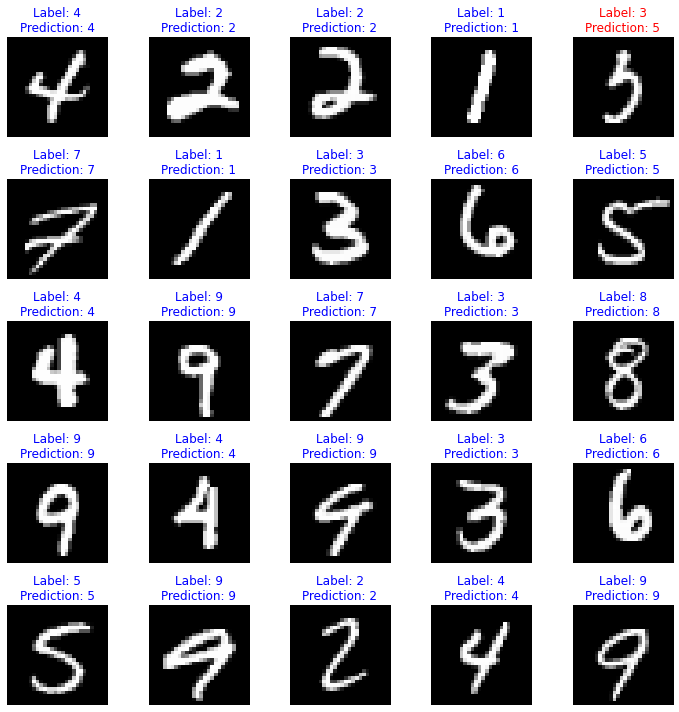

In [5]:
# Sample
num_sample = 25
col = int(np.ceil(np.sqrt(num_sample)))
row = int(np.ceil(num_sample/col))

idx = np.random.randint(0, len(mnist_test), num_sample)

sample_image = mnist_test.data[idx].type(torch.FloatTensor).to(device)/255.
sample_label = mnist_test.targets[idx]
prediction = torch.argmax(model(sample_image), dim=1).cpu().detach()

plt.figure(figsize=(col*2, row*2))
for i in range(num_sample):
    plt.subplot(col, row, i+1)
    color = "blue" if prediction[i] == sample_label[i] else "red"
    plt.imshow(sample_image[i].cpu(), cmap='gray')
    plt.title(f"Label: {sample_label[i]}\nPrediction: {prediction[i]}", color=color, fontsize=12)
    plt.axis("off")
plt.tight_layout()
plt.show()